<a href="https://colab.research.google.com/github/Hamidi-Oussama/Hamidi-Oussama/blob/main/Detector_of_age_gender_b_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download jangedoo/utkface-new

#! unzip <name-of-file>

 94% 311M/331M [00:01<00:00, 213MB/s]
100% 331M/331M [00:01<00:00, 198MB/s]


In [7]:
! unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [52]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [33]:
BASE_DIR = '/content/UTKFace'

In [34]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [35]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/50_0_3_20170117144239634.jpg....,50,0
1,/content/UTKFace/74_0_0_20170111222222432.jpg....,74,0
2,/content/UTKFace/21_1_0_20170116215450607.jpg....,21,1
3,/content/UTKFace/26_1_1_20170116153812488.jpg....,26,1
4,/content/UTKFace/26_0_0_20170113135336472.jpg....,26,0


In [36]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

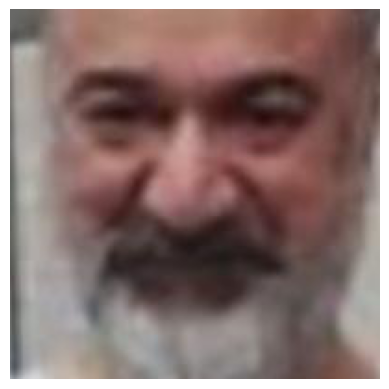

In [37]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

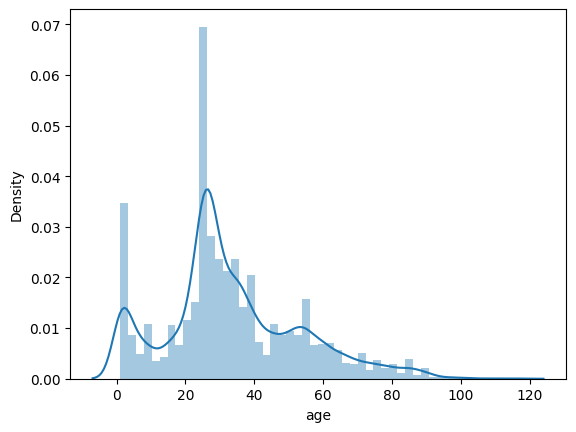

In [38]:

sns.distplot(df['age'])

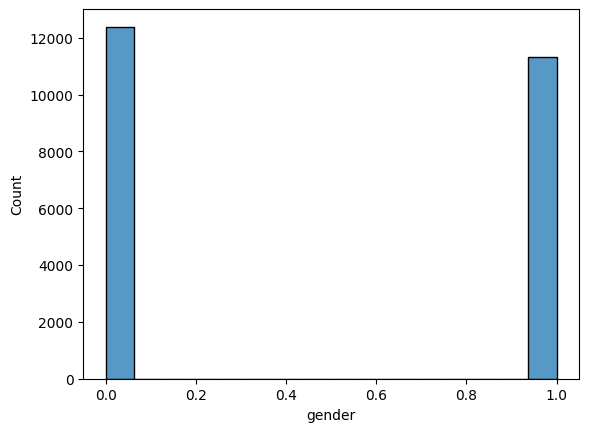

In [39]:
res =sns.histplot(df['gender'])
plt.show()

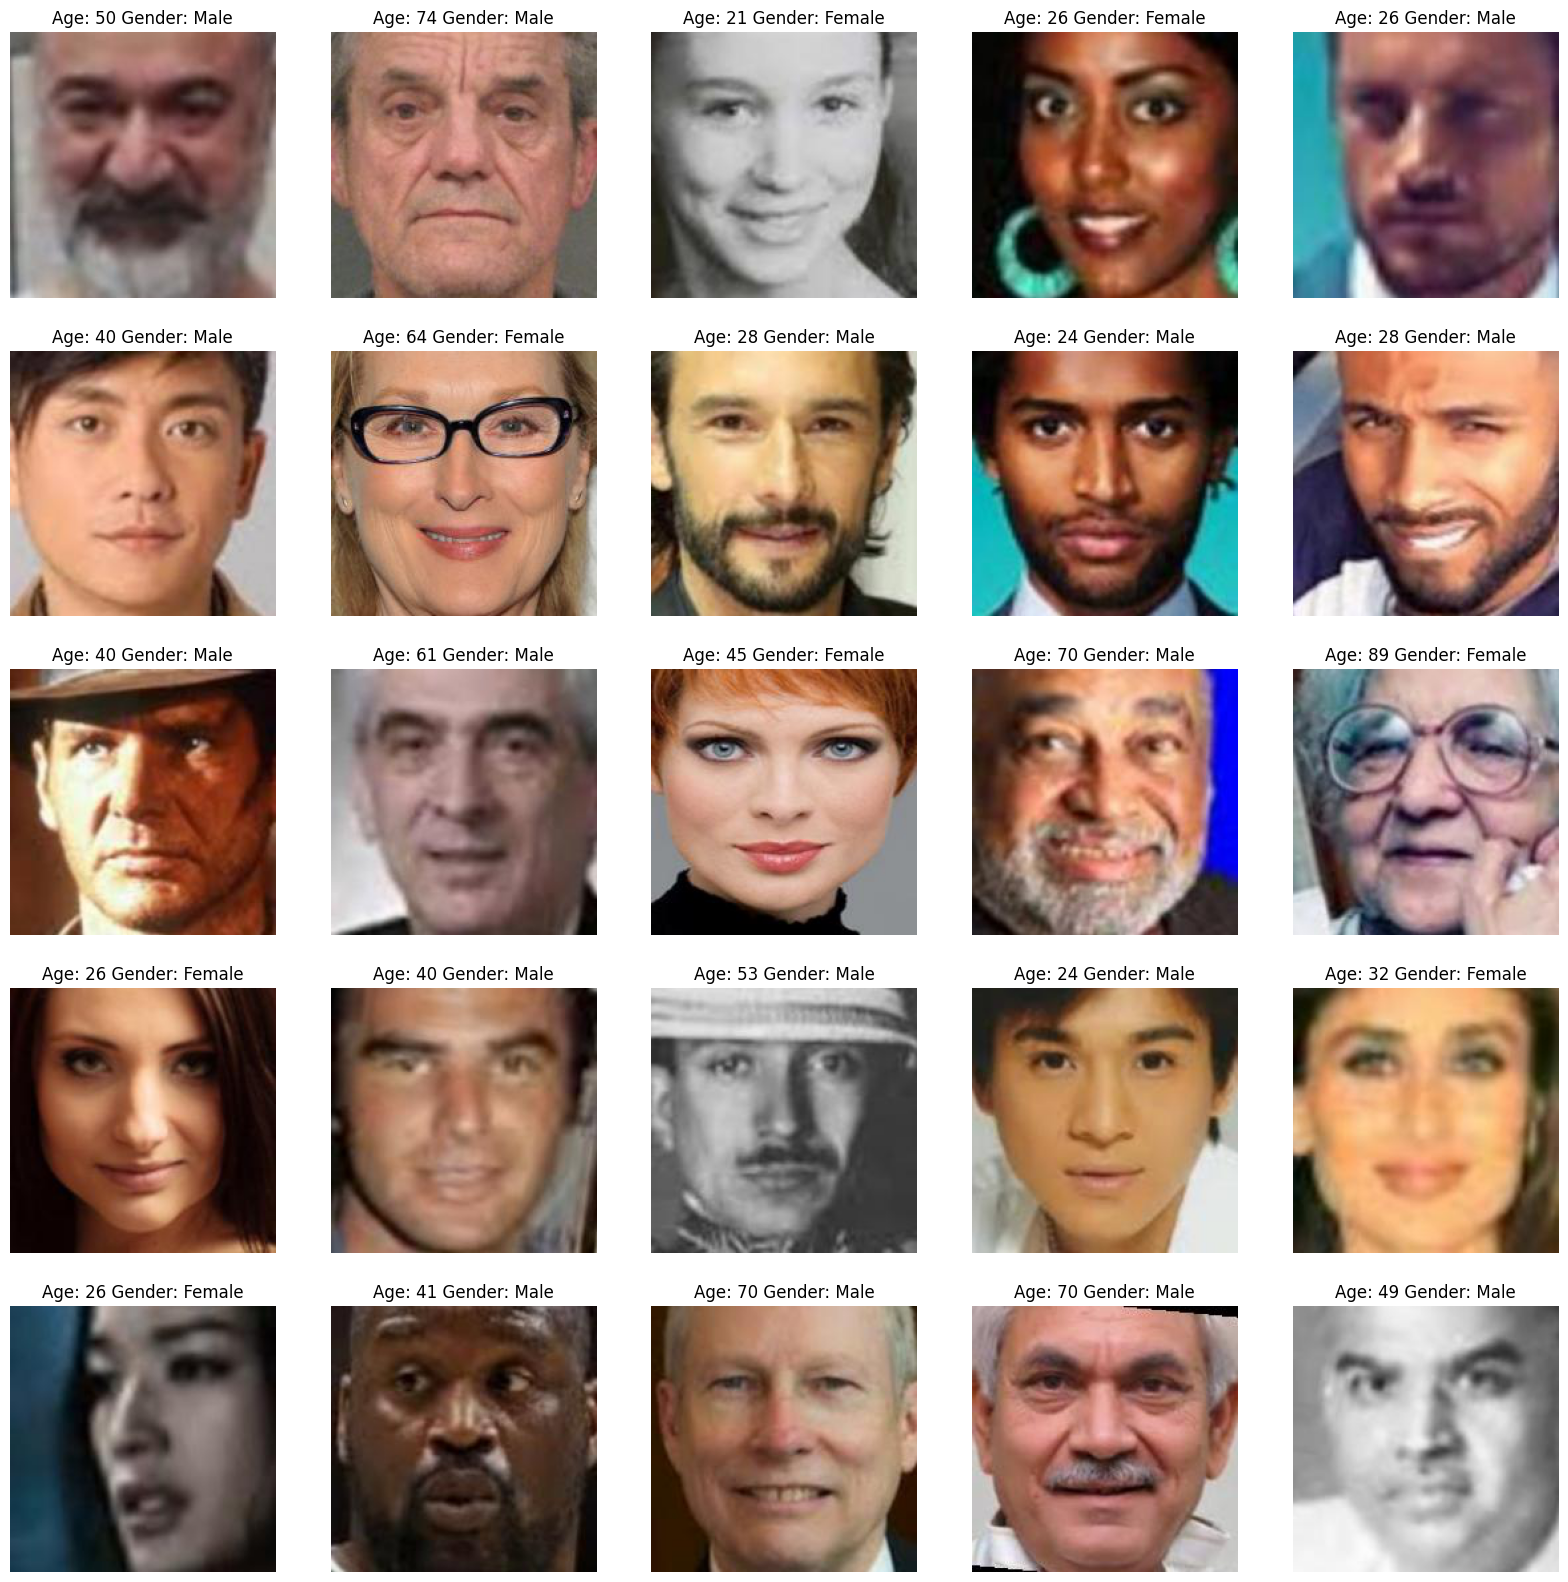

In [40]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [41]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [42]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [43]:
X.shape

(23708, 128, 128, 1)

In [44]:
X = X/255.0

In [45]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [46]:
input_shape = (128, 128, 1)

In [53]:
inputs = Input(shape=(128, 128, 1))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu',)(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

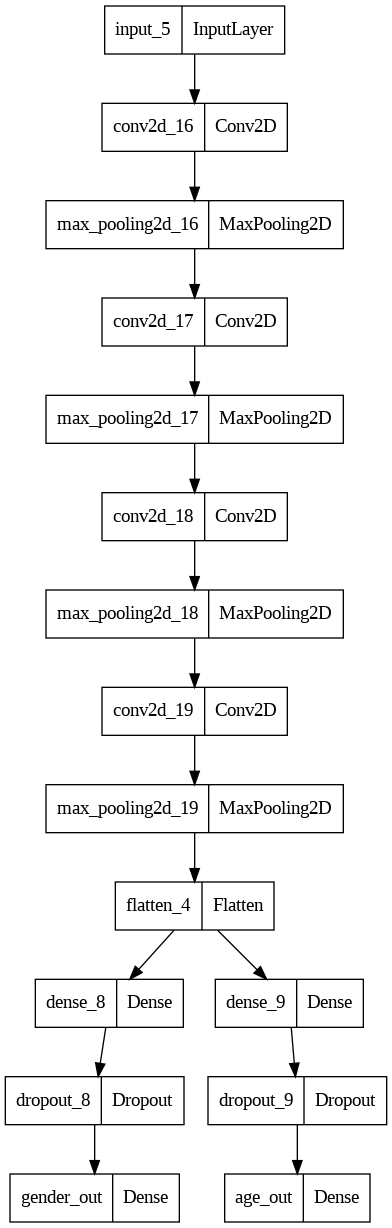

In [54]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [55]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 27s 22ms/step - loss: 15.6869 - gender_out_loss: 0.6631 - age_out_loss: 15.0239 - gender_out_accuracy: 0.5764 - age_out_accuracy: 0.0485 - val_loss: 12.3465 - val_gender_out_loss: 0.5350 - val_age_out_loss: 11.8115 - val_gender_out_accuracy: 0.7507 - val_age_out_accuracy: 0.0424
Epoch 2/30
593/593 [==============================] - 13s 21ms/step - loss: 11.3552 - gender_out_loss: 0.4740 - age_out_loss: 10.8812 - gender_out_accuracy: 0.7743 - age_out_accuracy: 0.0373 - val_loss: 10.6603 - val_gender_out_loss: 0.4209 - val_age_out_loss: 10.2393 - val_gender_out_accuracy: 0.8037 - val_age_out_accuracy: 0.0390
Epoch 3/30
593/593 [==============================] - 11s 19ms/step - loss: 9.8695 - gender_out_loss: 0.4044 - age_out_loss: 9.4651 - gender_out_accuracy: 0.8134 - age_out_accuracy: 0.0248 - val_loss: 9.1251 - val_gender_out_loss: 0.3474 - val_age_out_loss: 8.7778 - val_gender_out_accuracy: 0.8435 - val_age_out_accuracy: 0.0188
Ep

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 35
1/1 [==============================] - 0s 244ms/step
Predicted Gender: Male Predicted Age: 35


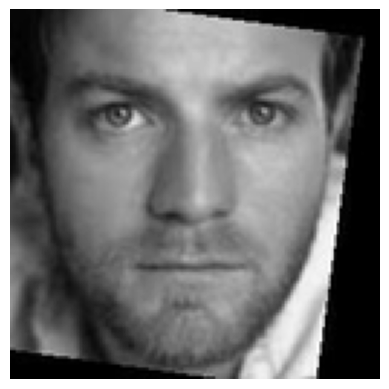

In [56]:
image_index = 9900
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 21
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Female Predicted Age: 20


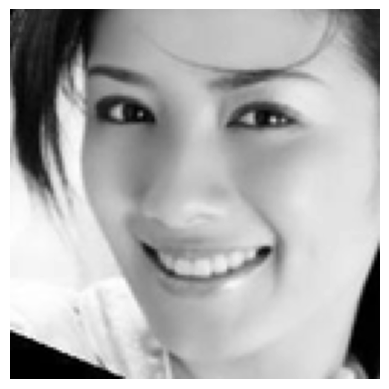

In [57]:
image_index = 6700
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 1
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Male Predicted Age: 2


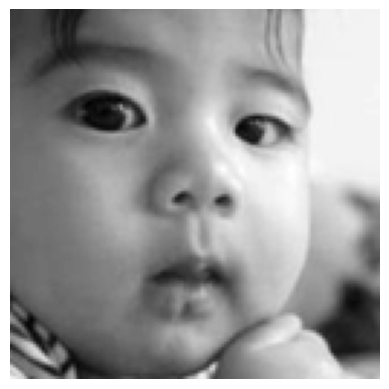

In [60]:
image_index = 1034
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');